## import & load

In [1]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

from collections import defaultdict
import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

In [3]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')
    os.environ["GOOGLE_CLOUD_PROJECT"] = "trading-290017"
else:
    print('the credential.json file does not exist')

import importlib

In [4]:
import market_data.ingest.bq.cache
importlib.reload(market_data.ingest.bq.cache)
importlib.reload(market_data.ingest.bq.candle)

<module 'market_data.ingest.bq.candle' from '/Users/junlim/projects/jitter_recovery/market_data/ingest/bq/candle.py'>

In [11]:
date_str_from='2024-01-14'
date_str_to='2024-02-01'
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE

In [14]:
df = market_data.ingest.bq.cache.fetch_and_cache(
    dataset_mode, 
    export_mode, 
    market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from=date_str_from, date_str_to=date_str_to).reset_index()
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])

In [15]:
all_symbols = df.symbol.unique()
all_symbols = [s for s in all_symbols if s]
len([s for s in all_symbols if 'USDT' in s])

164

## calculate/cache features

In [21]:
import algo.feature.jitter.calculate
importlib.reload(algo.feature.jitter.calculate)
import algo.feature.collective_jitter.calculate
importlib.reload(algo.feature.collective_jitter.calculate)
import algo.feature.jitter.research
importlib.reload(algo.feature.jitter.research)
import algo.feature.collective_jitter.research
importlib.reload(algo.feature.collective_jitter.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/Users/junlim/projects/jitter_recovery/algo/cache.py'>

In [22]:
feature_param = algo.feature.collective_jitter.calculate.CollectiveJitterFeatureParam(window=40, collective_window=30)

In [23]:
algo.feature.collective_jitter.research.get_feature_label_for_caching(feature_param)

'feature/(collectivechanges)_window(40)_collective_window(30)'

In [24]:
import market_data.ingest.bq.common
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE

In [26]:
dfst_feature = algo.cache.read_df(
    label = algo.feature.collective_jitter.research.get_feature_label_for_caching(feature_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from=date_str_from, 
    date_str_to=date_str_to)

## multiple symbols

In [27]:
import algo.alpha.jitter_recovery.calculate
importlib.reload(algo.alpha.jitter_recovery.calculate)
import algo.alpha.collective_jitter_recovery.calculate
importlib.reload(algo.alpha.collective_jitter_recovery.calculate)
import algo.alpha.jitter_recovery.research
importlib.reload(algo.alpha.jitter_recovery.research)
import algo.alpha.collective_jitter_recovery.research
importlib.reload(algo.alpha.collective_jitter_recovery.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/Users/junlim/projects/jitter_recovery/algo/cache.py'>

In [29]:
collective_feature_columns_no_rolling = ['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min']

In [30]:
df_collective_feature = dfst_feature.dropna().groupby('timestamp')[
    collective_feature_columns_no_rolling].median().resample('1min').asfreq().ffill()
df_collective_feature['ch_std'] = dfst_feature.dropna().groupby('timestamp')[
        ['ch']].std().resample('1min').asfreq().ffill().values
df_collective_feature['ch_window30_min'] = df_collective_feature.ch.rolling(window=30).min()
df_collective_feature['ch_window30_max'] = df_collective_feature.ch.rolling(window=30).max()

In [33]:
df_collective_feature = algo.feature.collective_jitter.research.get_df_collective_feature(dfst_feature)

AttributeError: module 'algo.feature.collective_jitter.research' has no attribute 'get_df_collective_feature'

In [34]:
dfst_feature.columns

Index(['index', 'open', 'high', 'low', 'close', 'volume',
       'avg_v_before_max_ch', 'avg_v_before_min_ch', 'ch', 'ch_max', 'ch_min',
       'ch_since_max', 'ch_since_min', 'distance_max_ch', 'distance_min_ch',
       'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from',
       'v_ch_min_is_to', 'value', 'ch_collective', 'ch_max_collective',
       'ch_min_collective', 'ch_since_max_collective',
       'ch_since_min_collective', 'ch_std_collective',
       'ch_window30_min_collective', 'ch_window30_max_collective'],
      dtype='object')

In [35]:
df_collective_feature.columns

Index(['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min', 'ch_std',
       'ch_window30_min', 'ch_window30_max'],
      dtype='object')

<AxesSubplot:xlabel='timestamp'>

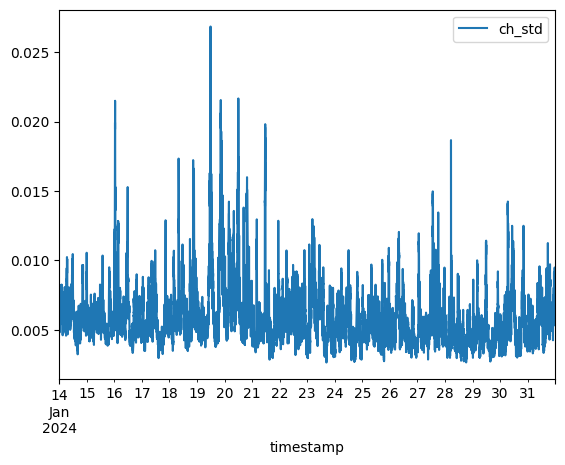

In [36]:
df_collective_feature[['ch_std']].plot()

In [79]:
dfst_with_collective_feature = algo.collective_jitter_recovery.research.append_collective_feature(df, dfst_feature)

In [80]:
dfst_with_collective_feature.columns

Index(['open', 'high', 'low', 'close', 'volume', 'avg_v_before_max_ch',
       'avg_v_before_min_ch', 'ch', 'ch_max', 'ch_min', 'ch_since_max',
       'ch_since_min', 'distance_max_ch', 'distance_min_ch',
       'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from',
       'v_ch_min_is_to', 'value', 'ch_collective', 'ch_max_collective',
       'ch_min_collective', 'ch_since_max_collective',
       'ch_since_min_collective', 'ch_std_collective',
       'ch_window30_min_collective', 'ch_window30_max_collective'],
      dtype='object')

In [37]:
dfst_feature[
    (dfst_feature.ch - dfst_feature.ch_collective) > 0.10
].index.get_level_values('symbol').unique()

Index(['TON-USDT-SWAP', 'AUCTION-USDT-SWAP', 'KLAY-USDT-SWAP',
       'TURBO-USDT-SWAP', 'USTC-USDT-SWAP', 'GAS-USDT-SWAP', 'CFX-USDT-SWAP',
       'UMA-USDT-SWAP', 'API3-USDT-SWAP', 'BAND-USDT-SWAP', 'CVC-USDT-SWAP',
       'GAL-USDT-SWAP', 'NMR-USDT-SWAP', 'AIDOGE-USDT-SWAP', 'FLOKI-USDT-SWAP',
       'LOOKS-USDT-SWAP', 'SWEAT-USDT-SWAP', 'CEL-USDT-SWAP', 'OMG-USDT-SWAP',
       'CETUS-USDT-SWAP', 'GFT-USDT-SWAP', 'TRB-USDT-SWAP', 'ALPHA-USDT-SWAP',
       'LUNA-USDT-SWAP', 'YFII-USDT-SWAP', 'WLD-USDT-SWAP'],
      dtype='object', name='symbol')

In [54]:
dfst_feature[
    (dfst_feature.ch - dfst_feature.ch_collective) < -0.10
].index.get_level_values('symbol').unique()

Index(['API3-USDT-SWAP', 'UMA-USDT-SWAP', 'YFII-USDT-SWAP', 'GFT-USDT-SWAP',
       'JUP-USDT-SWAP', 'WSM-USDT-SWAP'],
      dtype='object', name='symbol')

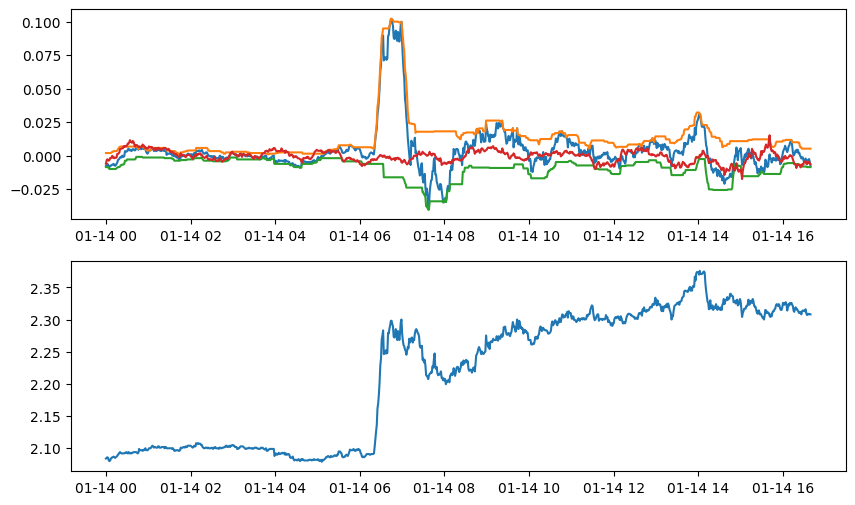

In [93]:
fig, (ax_ch, ax_close) = plt.subplots(2, figsize=(10, 6))
ax_ch.plot(dfst_feature.xs('TON-USDT-SWAP', level='symbol')[['ch', 'ch_max', 'ch_min', 'ch_collective']].iloc[0:1000])
ax_close.plot(dfst_feature.xs('TON-USDT-SWAP', level='symbol')[['close']].iloc[0:1000])

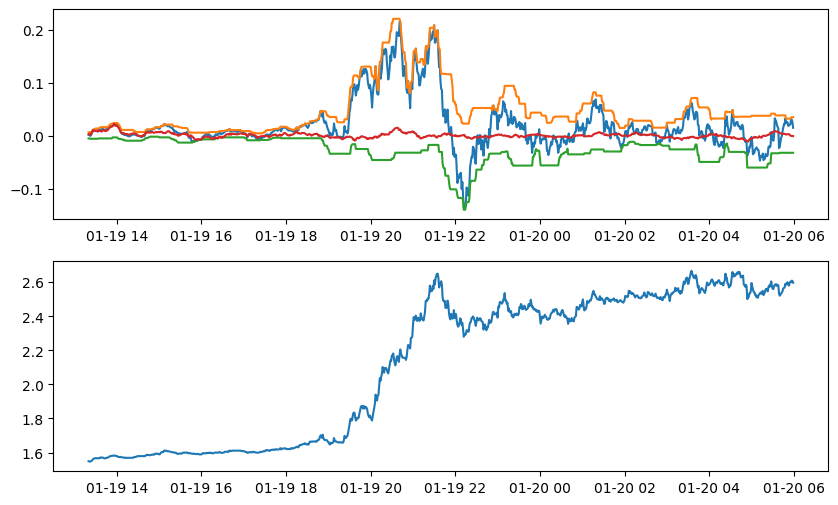

In [92]:
fig, (ax_ch, ax_close) = plt.subplots(2, figsize=(10, 6))
ax_ch.plot(dfst_feature.xs('API3-USDT-SWAP', level='symbol')[['ch', 'ch_max', 'ch_min', 'ch_collective']].iloc[8000:9000])
ax_close.plot(dfst_feature.xs('API3-USDT-SWAP', level='symbol')[['close']].iloc[8000:9000])

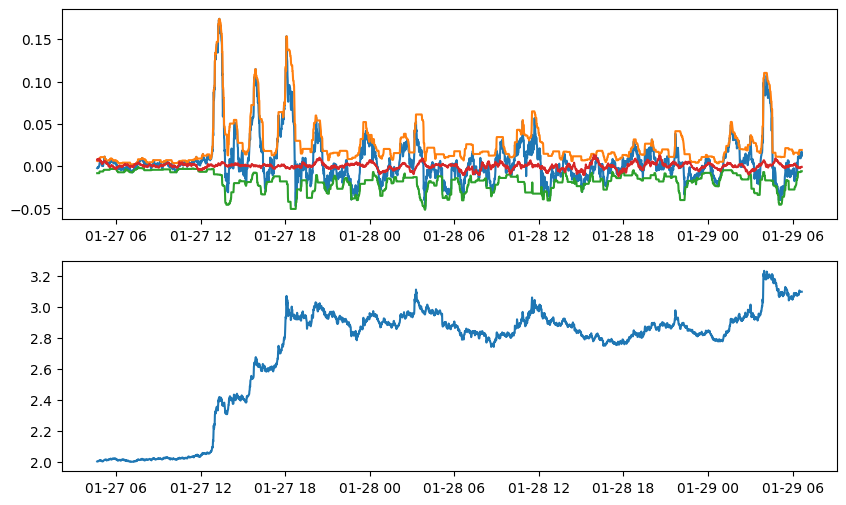

In [91]:
fig, (ax_ch, ax_close) = plt.subplots(2, figsize=(10, 6))
ax_ch.plot(dfst_feature.xs('API3-USDT-SWAP', level='symbol')[['ch', 'ch_max', 'ch_min', 'ch_collective']].iloc[19000:22000])
ax_close.plot(dfst_feature.xs('API3-USDT-SWAP', level='symbol')[['close']].iloc[19000:22000])

<AxesSubplot:xlabel='timestamp'>

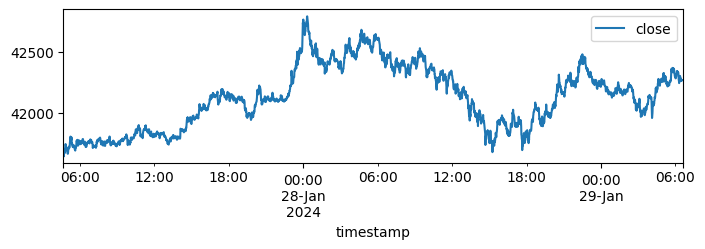

In [71]:
dfst_feature.xs('BTC-USDT-SWAP', level='symbol')[['close']].iloc[19000:22000].plot(figsize=(8,2))

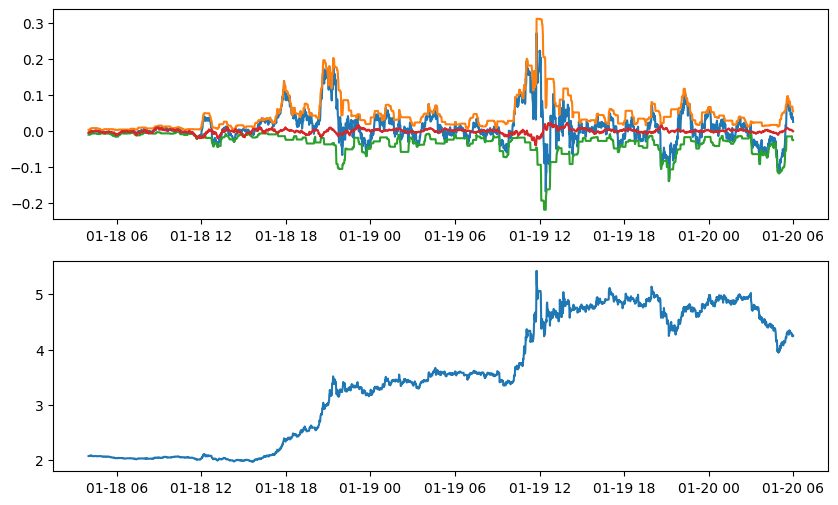

In [90]:
fig, (ax_ch, ax_close) = plt.subplots(2, figsize=(10, 6))
ax_ch.plot(dfst_feature.xs('UMA-USDT-SWAP', level='symbol')[['ch', 'ch_max', 'ch_min', 'ch_collective']].iloc[6000:9000])
ax_close.plot(dfst_feature.xs('UMA-USDT-SWAP', level='symbol')[['close']].iloc[6000:9000])

In [49]:
dfst_feature.xs('TON-USDT-SWAP', level='symbol').columns

Index(['index', 'open', 'high', 'low', 'close', 'volume',
       'avg_v_before_max_ch', 'avg_v_before_min_ch', 'ch', 'ch_max', 'ch_min',
       'ch_since_max', 'ch_since_min', 'distance_max_ch', 'distance_min_ch',
       'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from',
       'v_ch_min_is_to', 'value', 'ch_collective', 'ch_max_collective',
       'ch_min_collective', 'ch_since_max_collective',
       'ch_since_min_collective', 'ch_std_collective',
       'ch_window30_min_collective', 'ch_window30_max_collective'],
      dtype='object')

In [85]:
dfst_with_collective_feature[
    (dfst_with_collective_feature.ch - dfst_with_collective_feature.ch_collective) > 0.10
].index.get_level_values('symbol').unique()

Index(['RAY-USDT-SWAP', 'YGG-USDT-SWAP', 'JOE-USDT-SWAP', 'ZRX-USDT-SWAP',
       'JUP-USDT-SWAP', 'SWEAT-USDT-SWAP', 'FRONT-USDT-SWAP',
       'DMAIL-USDT-SWAP', 'GPT-USDT-SWAP', 'LPT-USDT-SWAP', 'OM-USDT-SWAP',
       'FLR-USDT-SWAP', 'BONE-USDT-SWAP', 'MASK-USDT-SWAP'],
      dtype='object', name='symbol')

In [ ]:
dfst_with_collective_feature[
    (dfst_with_collective_feature.)
]

<AxesSubplot:xlabel='timestamp'>

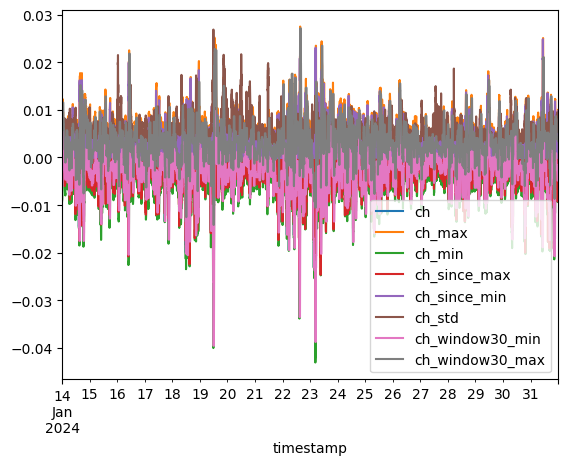

In [38]:
df_collective_feature.plot()

In [39]:
df_collective_feature = dfst_feature.dropna().groupby('timestamp')[collective_feature_columns_no_rolling].median().resample('1min').asfreq().ffill()
df_collective_feature['ch_window30_min'] = df_collective_feature.ch.rolling(window=30).min() 
df_collective_feature['ch_window30_max'] = df_collective_feature.ch.rolling(window=30).max() 
df_collective_feature['ch_window60_min'] = df_collective_feature.ch.rolling(window=60).min() 
df_collective_feature['ch_window60_max'] = df_collective_feature.ch.rolling(window=60).max() 

<AxesSubplot:xlabel='timestamp'>

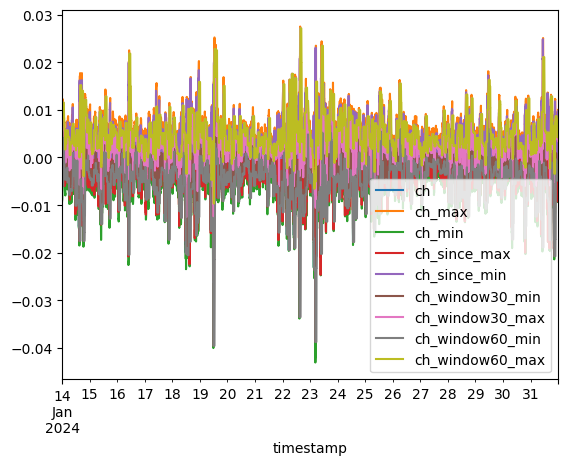

In [40]:
df_collective_feature.plot()

array([[<Axes: title={'center': 'profit'}>]], dtype=object)

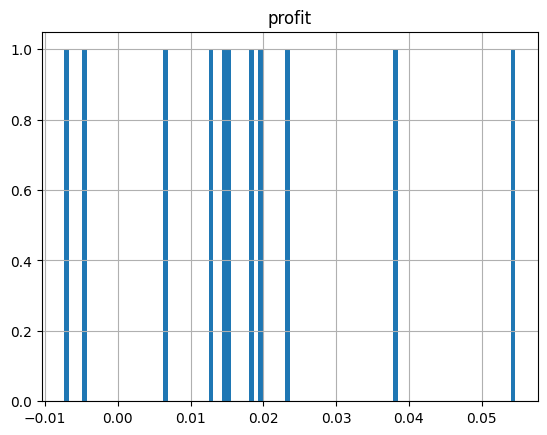

In [105]:
dfst_trading[dfst_trading.profit != 0][['profit']].dropna().groupby('symbol').sum().sort_values('profit').hist(bins=100)

In [615]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if 'PERP' not in row['symbol']: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 12:13:00, PERP-USDT-SWAP, 1.6581, position_changed: 1.0
2024-01-03 12:16:00, PERP-USDT-SWAP, 1.8838, position_changed: -1.0
2024-01-03 12:17:00, PERP-USDT-SWAP, 1.8575, position_changed: 1.0
2024-01-03 12:18:00, PERP-USDT-SWAP, 1.8033, position_changed: -1.0
2024-01-03 12:19:00, PERP-USDT-SWAP, 1.6796, position_changed: 1.0
2024-01-03 12:23:00, PERP-USDT-SWAP, 1.81, position_changed: -1.0
2024-01-03 12:24:00, PERP-USDT-SWAP, 1.8786, position_changed: 1.0
2024-01-03 12:25:00, PERP-USDT-SWAP, 1.801, position_changed: -1.0
2024-01-03 12:26:00, PERP-USDT-SWAP, 1.8229, position_changed: 1.0
2024-01-03 12:27:00, PERP-USDT-SWAP, 1.7579, position_changed: -1.0
2024-01-03 12:28:00, PERP-USDT-SWAP, 1.81, position_changed: 1.0
2024-01-03 12:29:00, PERP-USDT-SWAP, 1.8183, position_changed: -1.0
